# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset import Dataset
from utils import *
import config 

# import the necessary packages
from albumentations.pytorch import ToTensorV2
from imutils import paths
from skimage import io
from sklearn.model_selection import train_test_split
from torch import optim
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from tqdm import tqdm
from utils import EarlyStopping
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import random
import segmentation_models_pytorch as smp
import time
import torch
import torchmetrics
import os

## Controlling sources of randomness

In [2]:
# Set seed
SEED = 42
seed_all(SEED)

## Setup CUDA

In [3]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [4]:
# load the image and label filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/medium/images")))
labelPaths = sorted(list(paths.list_images("/data/jantina/CoralNet/dataset/medium/labels")))


trainImages, testImages, trainLabels, testLabels = train_test_split(imagePaths,
                                                                    labelPaths,
                                                                    test_size=0.2,
                                                                    train_size=0.8,
                                                                    random_state=SEED)
testImages, valImages, testLabels, valLabels = train_test_split(testImages, 
                                                                  testLabels,
                                                                  test_size=0.5,
                                                                  train_size=0.5,
                                                                  random_state=SEED)

# get the masks corresponding to the labels
trainMasks = [s.replace('labels', 'masks_9x9') for s in trainLabels]
valMasks = [s.replace('labels', 'masks_9x9') for s in valLabels]

# save testing images to disk
print("[INFO] saving testing image paths...")
f = open("/data/jantina/CoralNet/dataset/medium/output/test_paths.txt", "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Example

In [5]:
# new label classes
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'seagrass',
           9: 'unknown',
           0: 'no label'
          }

In [6]:
a=random.randrange(len(trainImages))
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])

print(f"Image name: {trainImages[a].split('/')[-1]}")
print(f"Image dtype: {image.dtype}, Label dtype: {label.dtype}")

Image name: 2020-06-23-ADELUP-A-T1 12.5-B (P6230581).JPG
Image dtype: uint8, Label dtype: uint8


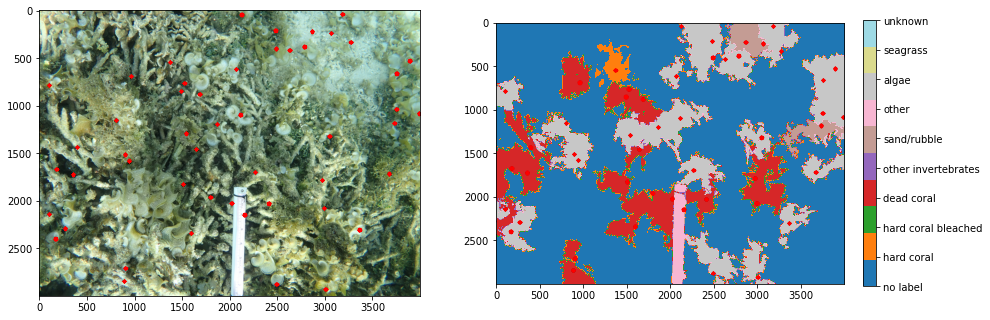

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)
ax[0].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cax = ax[1].imshow(label, cmap = plt.cm.get_cmap('tab20', 10), vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[1], np.nonzero(mask)[0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [8]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), 
                        interpolation=cv2.INTER_NEAREST),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

In [9]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33), 
                        interpolation=cv2.INTER_NEAREST),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()],
    additional_targets={'mask2': 'mask'}
)

## Example Transforms

In [10]:
image = io.imread(trainImages[a])
label = io.imread(trainLabels[a])
mask = io.imread(trainMasks[a])
transformed = train_transform(image=image, mask=label, mask2=mask)
image = transformed["image"]
label = transformed["mask"]
mask = transformed["mask2"]
            
# convert label and mask to long tensor
label = label.type(torch.LongTensor)
mask = mask.type(torch.LongTensor)

/tmp/ipykernel_329655/1473477371.py:10: MatplotlibDeprecationWarning:

Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().



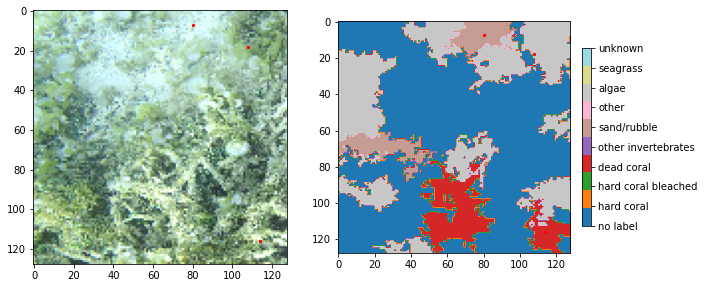

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))
ax[0].imshow(unnormalize(image).permute(1, 2, 0))
ax[0].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

ax[1].imshow(label,
             cmap = plt.cm.get_cmap('tab20', 10), 
             vmin=0, vmax=9)
ax[1].scatter(np.nonzero(mask)[:,1], np.nonzero(mask)[:,0], s=20, marker='.', c='r')

cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Create dataset

In [12]:
# create the train and validation datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, labelPaths = trainLabels, maskPaths=trainMasks, transform=train_transform)
valDS = Dataset(imagePaths=valImages, labelPaths = valLabels, maskPaths=valMasks, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")
print(f"[INFO] found {len(testImages)} examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 3726 examples in the training set
[INFO] found 466 examples in the validation set
[INFO] found 466 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [13]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}, Feature type: {sample[0].dtype}")
print(f"Label shape: {sample[1].shape}, Label type: {sample[1].dtype}")
print(f"Mask shape: {sample[2].shape}, Mask type: {sample[2].dtype}")

Feature shape: torch.Size([3, 128, 128]), Feature type: torch.float32
Label shape: torch.Size([128, 128]), Label type: torch.int64
Mask shape: torch.Size([128, 128]), Mask type: torch.int64


In [14]:
config.BATCH_SIZE = 466

In [15]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True,
                         worker_init_fn=seed_worker)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True,
                       worker_init_fn=seed_worker)

In [16]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:466
[INFO] num_workers:32


## Model initialization

In [17]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=len(classes)
)

In [18]:
# initialize model
unet = model.to(config.DEVICE)

# class weights
#w = np.array([0, 0.83332256, 0.99374076, 0.55343069, 0.97986531, 0.79508821, 0.98954279, 0.85796154, 0.99934462, 0.9977035])
#cw = torch.tensor([w[0], w[1], w[2], w[3], w[4], w[5], w[6], w[7], w[8], w[9]], dtype=torch.float32).to(config.DEVICE) 
#lossFunc = CrossEntropyLoss(ignore_index=0, weight=cw)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=0)

config.INIT_LR = 10*(1e-4 * config.BATCH_SIZE / 10)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(valDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

In [19]:
# initialize metrics
acc = torchmetrics.Accuracy(ignore_index=0)

# move the metrics to device
acc.to(config.DEVICE)

# initialize a dictionary to store metrics history
metrics = {"train_accuracyGT": [], "val_accuracyGT": [],
          "train_accuracyAGT": [], "val_accuracyAGT": [],
          "train_accuracyAGT2": [], "val_accuracyAGT2": []}

In [20]:
# initialize the early_stopping object
early_stopping = EarlyStopping(patience=10, verbose=True, 
                               path="/data/jantina/CoralNet/dataset/medium/output/checkpoint.pt")

In [21]:
#initialize scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(opt, "min", patience=4, verbose=1)
grad_scaler = torch.cuda.amp.GradScaler(enabled=False)

## Training loop

In [22]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    #fix seed
    seed_all(SEED)
    
    ###################
    # train the model #
    ###################
    unet.train() # prep model for training

    # initialize the total training and validation loss
    totalTrainLoss, totalValLoss = 0, 0
    
    # initialize the accuracy
    accTrainGT = 0
    accTrainAGT = 0
    accTrainAGT2 = 0
    accValGT = 0
    accValAGT = 0
    accValAGT2 = 0
    countTrainGT = 0
    countTrainAGT = 0
    countTrainAGT2 = 0
    countValGT = 0
    countValAGT = 0
    countValAGT2 = 0
    
    # loop over the training set
    for batch, (data, target, mask) in enumerate(trainLoader, 1):
        #fix seed
        seed_all(SEED)
        
        # send the input to the device
        (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(data)

        # calculate the training loss
        loss = lossFunc(pred, target)
        
        # for each input
        for i in range(len(target)):
            if torch.sum(mask[i])!=0: # GT and AGT
                # update the accuracy count
                countTrainGT = countTrainGT + 1
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # extract the GT label positions in the prediction
                pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                # extract the GT label positions in the target
                pixel_targGT = torch.mul(mask[i], target[i])
                # metrics on current element
                accTrainGT += acc(pixel_predGT, pixel_targGT).item()
                
                # extract the AGT label positions in the prediction
                pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                # extract the AGT label positions in the target
                pixel_targAGT = target[i]-pixel_targGT
                # metrics on current element
                accTrainAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                
            else: # only AGT
                # update the accuracy count
                countTrainAGT = countTrainAGT + 1
                countTrainAGT2 = countTrainAGT2 + 1
                # metrics on current element
                accTrainAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                    countTrainAGT = countTrainAGT - 1
                else:
                    accTrainAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
            
        # Gradient descent with optimizer:
        opt.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        grad_scaler.step(opt)
        grad_scaler.update()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # switch off autograd
    with torch.no_grad():        
        unet.eval() # prep model for evaluation
        
        # loop over the validation set
        for data, target, mask in valLoader:
            #fix seed
            seed_all(SEED)
            
            # send the input to the device
            (data, target, mask) = (data.to(config.DEVICE), target.to(config.DEVICE), mask.to(config.DEVICE))
        
            # make the predictions 
            pred = unet(data)
            
            # calculate the validation loss
            totalValLoss += lossFunc(pred, target).item()
            
            # scheduler step
            scheduler.step(lossFunc(pred, target))
            
            # for each input
            for i in range(len(target)):
                if torch.sum(mask[i])!=0: # GT and AGT
                    # update the accuracy count
                    countValGT = countValGT + 1
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # extract the GT label positions in the prediction
                    pixel_predGT = torch.mul(mask[i], torch.argmax(pred[i],dim=0))
                    # extract the GT label positions in the target
                    pixel_targGT = torch.mul(mask[i], target[i])
                    # metrics on current element
                    accValGT += acc(pixel_predGT, pixel_targGT).item()

                    # extract the AGT label positions in the prediction
                    pixel_predAGT = torch.argmax(pred[i],dim=0)-pixel_predGT
                    # extract the AGT label positions in the target
                    pixel_targAGT = target[i]-pixel_targGT
                    # metrics on current element
                    accValAGT2 += acc(pixel_predAGT, pixel_targAGT).item()
                    if np.isnan(accuracyAGT(pixel_predAGT, pixel_targAGT).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(pixel_predAGT, pixel_targAGT).item()
                    
                    '''                                    
                    # show the validation results
                    fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
                    ax[0].imshow(unnormalize(data[i]).cpu().detach().permute(1, 2, 0))
                    ax[0].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    ax[1].imshow(target[i].cpu(),
                                 cmap = plt.cm.get_cmap('tab20', 10), 
                                 vmin=0, vmax=9)
                    ax[1].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')



                    cax = ax[2].imshow(torch.argmax(pred[i],dim=0).cpu(),
                                       cmap = plt.cm.get_cmap('tab20', 10),
                                       vmin=0, vmax=9)


                    cax = ax[2].imshow(torch.softmax(pred[i],dim=1)[3].cpu())
                    
                    ax[2].scatter(np.nonzero(mask[i])[:,1].cpu(), np.nonzero(mask[i])[:,0].cpu(), s=20, marker='.', c='r')

                    cbar = fig.colorbar(cax, fraction=0.035)
                    #cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
                    #cbar.ax.set_yticklabels(list(classes.values()))
                    plt.show()
                    '''
                    
                else: # only AGT
                    # update the accuracy count
                    countValAGT = countValAGT + 1
                    countValAGT2 = countValAGT2 + 1
                    # metrics on current element
                    accValAGT2 += acc(torch.argmax(pred[i],dim=0), target[i]).item()
                    if np.isnan(accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()):
                        countValAGT = countValAGT - 1
                    else:
                        accValAGT += accuracyAGT(torch.argmax(pred[i],dim=0), target[i]).item()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # calculate the average metrics
    avgaccTrainGT = accTrainGT / countTrainGT
    avgaccTrainAGT = accTrainAGT / countTrainAGT
    avgaccValGT = accValGT / countValGT
    avgaccValAGT = accValAGT / countValAGT 
    avgaccTrainAGT2 = accTrainAGT2 / countTrainAGT2
    avgaccValAGT2 = accValAGT2 / countValAGT2
    
    # update our metrics history
    metrics["train_accuracyGT"].append(avgaccTrainGT)
    metrics["val_accuracyGT"].append(avgaccValGT)
    metrics["train_accuracyAGT"].append(avgaccTrainAGT)
    metrics["val_accuracyAGT"].append(avgaccValAGT)
    metrics["train_accuracyAGT2"].append(avgaccTrainAGT2)
    metrics["val_accuracyAGT2"].append(avgaccValAGT2)
    
    # check early stopping
    early_stopping(avgValLoss, unet)
    if early_stopping.early_stop:
        print("Early stopping")
        break
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
    # print the model metrics information
    print("GT Train Accuracy: {:.4f}".format(avgaccTrainGT))
    print("AGT Train Accuracy: {:.4f}".format(avgaccTrainAGT))
    print("AGT 2 Train Accuracy: {:.4f}".format(avgaccTrainAGT2))
    print("GT Val Accuracy: {:.4f}".format(avgaccValGT))
    print("AGT Val Accuracy: {:.4f}".format(avgaccValAGT))
    print("AGT 2 Val Accuracy: {:.4f}".format(avgaccValAGT2))
    
# load the last checkpoint with the best model
unet.load_state_dict(torch.load("/data/jantina/CoralNet/dataset/medium/output/checkpoint.pt"))

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  1%|█▎                                                                                                                            | 1/100 [02:52<4:45:03, 172.76s/it]

Validation loss decreased (inf --> 1549765760.000000).  Saving model ...
[INFO] EPOCH: 1/100
Train loss: 1.954959, Validation loss: 1549765760.0000
GT Train Accuracy: 0.2818
AGT Train Accuracy: inf
AGT 2 Train Accuracy: 0.2940
GT Val Accuracy: 0.1027
AGT Val Accuracy: 0.1087
AGT 2 Val Accuracy: 0.1072


  2%|██▌                                                                                                                           | 2/100 [05:39<4:36:26, 169.25s/it]

Validation loss decreased (1549765760.000000 --> 80467.195312).  Saving model ...
[INFO] EPOCH: 2/100
Train loss: 1.700040, Validation loss: 80467.1953
GT Train Accuracy: 0.3065
AGT Train Accuracy: 0.3222
AGT 2 Train Accuracy: 0.3204
GT Val Accuracy: 0.1791
AGT Val Accuracy: 0.1871
AGT 2 Val Accuracy: 0.1848


  3%|███▊                                                                                                                          | 3/100 [08:27<4:32:30, 168.56s/it]

Validation loss decreased (80467.195312 --> 62.842014).  Saving model ...
[INFO] EPOCH: 3/100
Train loss: 1.678748, Validation loss: 62.8420
GT Train Accuracy: 0.3059
AGT Train Accuracy: 0.3240
AGT 2 Train Accuracy: 0.3222
GT Val Accuracy: 0.2976
AGT Val Accuracy: 0.2854
AGT 2 Val Accuracy: 0.2839


  4%|█████                                                                                                                         | 4/100 [11:14<4:28:40, 167.92s/it]

Validation loss decreased (62.842014 --> 1.411309).  Saving model ...
[INFO] EPOCH: 4/100
Train loss: 1.609477, Validation loss: 1.4113
GT Train Accuracy: 0.4056
AGT Train Accuracy: 0.4097
AGT 2 Train Accuracy: 0.4078
GT Val Accuracy: 0.4837
AGT Val Accuracy: 0.4890
AGT 2 Val Accuracy: 0.4875


  5%|██████▎                                                                                                                       | 5/100 [13:58<4:23:32, 166.45s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 5/100
Train loss: 1.529838, Validation loss: 3.3129
GT Train Accuracy: 0.5002
AGT Train Accuracy: 0.4999
AGT 2 Train Accuracy: 0.4981
GT Val Accuracy: 0.3791
AGT Val Accuracy: 0.4157
AGT 2 Val Accuracy: 0.4142


  6%|███████▌                                                                                                                      | 6/100 [16:38<4:17:19, 164.25s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 6/100
Train loss: 1.485767, Validation loss: 3.1179
GT Train Accuracy: 0.5217
AGT Train Accuracy: 0.5198
AGT 2 Train Accuracy: 0.5174
GT Val Accuracy: 0.5586
AGT Val Accuracy: 0.5284
AGT 2 Val Accuracy: 0.5257


  7%|████████▊                                                                                                                     | 7/100 [19:16<4:11:44, 162.42s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 7/100
Train loss: 1.458749, Validation loss: 1.4158
GT Train Accuracy: 0.5291
AGT Train Accuracy: 0.5236
AGT 2 Train Accuracy: 0.5218
GT Val Accuracy: 0.5258
AGT Val Accuracy: 0.5187
AGT 2 Val Accuracy: 0.5172


  8%|██████████                                                                                                                    | 8/100 [21:56<4:07:38, 161.51s/it]

Validation loss decreased (1.411309 --> 1.368205).  Saving model ...
[INFO] EPOCH: 8/100
Train loss: 1.440604, Validation loss: 1.3682
GT Train Accuracy: 0.5532
AGT Train Accuracy: 0.5361
AGT 2 Train Accuracy: 0.5342
GT Val Accuracy: 0.5998
AGT Val Accuracy: 0.5559
AGT 2 Val Accuracy: 0.5543


  9%|███████████▎                                                                                                                  | 9/100 [24:36<4:04:22, 161.12s/it]

Validation loss decreased (1.368205 --> 1.303617).  Saving model ...
[INFO] EPOCH: 9/100
Train loss: 1.425876, Validation loss: 1.3036
GT Train Accuracy: 0.5527
AGT Train Accuracy: 0.5436
AGT 2 Train Accuracy: 0.5418
GT Val Accuracy: 0.5778
AGT Val Accuracy: 0.5608
AGT 2 Val Accuracy: 0.5592


 10%|████████████▌                                                                                                                | 10/100 [27:16<4:01:20, 160.89s/it]

Validation loss decreased (1.303617 --> 1.253532).  Saving model ...
[INFO] EPOCH: 10/100
Train loss: 1.433931, Validation loss: 1.2535
GT Train Accuracy: 0.5543
AGT Train Accuracy: 0.5460
AGT 2 Train Accuracy: 0.5440
GT Val Accuracy: 0.5603
AGT Val Accuracy: 0.5673
AGT 2 Val Accuracy: 0.5658


 11%|█████████████▊                                                                                                               | 11/100 [30:00<3:59:50, 161.69s/it]

Validation loss decreased (1.253532 --> 1.239264).  Saving model ...
[INFO] EPOCH: 11/100
Train loss: 1.415248, Validation loss: 1.2393
GT Train Accuracy: 0.5588
AGT Train Accuracy: 0.5518
AGT 2 Train Accuracy: 0.5498
GT Val Accuracy: 0.6010
AGT Val Accuracy: 0.5798
AGT 2 Val Accuracy: 0.5784


 12%|███████████████                                                                                                              | 12/100 [32:40<3:56:28, 161.24s/it]

Validation loss decreased (1.239264 --> 1.193121).  Saving model ...
[INFO] EPOCH: 12/100
Train loss: 1.400517, Validation loss: 1.1931
GT Train Accuracy: 0.5700
AGT Train Accuracy: 0.5593
AGT 2 Train Accuracy: 0.5573
GT Val Accuracy: 0.5963
AGT Val Accuracy: 0.5792
AGT 2 Val Accuracy: 0.5778


 13%|████████████████▎                                                                                                            | 13/100 [35:21<3:53:50, 161.27s/it]

Validation loss decreased (1.193121 --> 1.183660).  Saving model ...
[INFO] EPOCH: 13/100
Train loss: 1.397089, Validation loss: 1.1837
GT Train Accuracy: 0.5658
AGT Train Accuracy: 0.5611
AGT 2 Train Accuracy: 0.5588
GT Val Accuracy: 0.6101
AGT Val Accuracy: 0.5765
AGT 2 Val Accuracy: 0.5750


 14%|█████████████████▌                                                                                                           | 14/100 [38:03<3:51:19, 161.39s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 14/100
Train loss: 1.385271, Validation loss: 1.2093
GT Train Accuracy: 0.5668
AGT Train Accuracy: 0.5642
AGT 2 Train Accuracy: 0.5623
GT Val Accuracy: 0.5782
AGT Val Accuracy: 0.5708
AGT 2 Val Accuracy: 0.5693


 15%|██████████████████▊                                                                                                          | 15/100 [40:46<3:49:13, 161.81s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 15/100
Train loss: 1.401094, Validation loss: 1.1862
GT Train Accuracy: 0.5828
AGT Train Accuracy: 0.5596
AGT 2 Train Accuracy: 0.5578
GT Val Accuracy: 0.5538
AGT Val Accuracy: 0.5588
AGT 2 Val Accuracy: 0.5573


 16%|████████████████████                                                                                                         | 16/100 [43:29<3:47:06, 162.22s/it]

Validation loss decreased (1.183660 --> 1.159188).  Saving model ...
[INFO] EPOCH: 16/100
Train loss: 1.381272, Validation loss: 1.1592
GT Train Accuracy: 0.5741
AGT Train Accuracy: 0.5636
AGT 2 Train Accuracy: 0.5619
GT Val Accuracy: 0.6065
AGT Val Accuracy: 0.5925
AGT 2 Val Accuracy: 0.5909


 17%|█████████████████████▎                                                                                                       | 17/100 [46:14<3:45:22, 162.92s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 17/100
Train loss: 1.393810, Validation loss: 1.2208
GT Train Accuracy: 0.5753
AGT Train Accuracy: 0.5586
AGT 2 Train Accuracy: 0.5568
GT Val Accuracy: 0.5548
AGT Val Accuracy: 0.5620
AGT 2 Val Accuracy: 0.5605


 18%|██████████████████████▌                                                                                                      | 18/100 [48:56<3:42:23, 162.73s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 18/100
Train loss: 1.380093, Validation loss: 1.1872
GT Train Accuracy: 0.5719
AGT Train Accuracy: 0.5653
AGT 2 Train Accuracy: 0.5635
GT Val Accuracy: 0.5832
AGT Val Accuracy: 0.5863
AGT 2 Val Accuracy: 0.5847


 19%|███████████████████████▊                                                                                                     | 19/100 [51:39<3:39:55, 162.91s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 19/100
Train loss: 1.378456, Validation loss: 1.1792
GT Train Accuracy: 0.5800
AGT Train Accuracy: 0.5674
AGT 2 Train Accuracy: 0.5648
GT Val Accuracy: 0.6185
AGT Val Accuracy: 0.5843
AGT 2 Val Accuracy: 0.5828


 20%|█████████████████████████                                                                                                    | 20/100 [54:21<3:36:40, 162.51s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 20/100
Train loss: 1.377650, Validation loss: 1.2606
GT Train Accuracy: 0.5768
AGT Train Accuracy: 0.5635
AGT 2 Train Accuracy: 0.5614
GT Val Accuracy: 0.5353
AGT Val Accuracy: 0.5314
AGT 2 Val Accuracy: 0.5299


 21%|██████████████████████████▎                                                                                                  | 21/100 [57:05<3:34:42, 163.07s/it]

Validation loss decreased (1.159188 --> 1.135679).  Saving model ...
[INFO] EPOCH: 21/100
Train loss: 1.369000, Validation loss: 1.1357
GT Train Accuracy: 0.5761
AGT Train Accuracy: 0.5667
AGT 2 Train Accuracy: 0.5649
GT Val Accuracy: 0.6043
AGT Val Accuracy: 0.5968
AGT 2 Val Accuracy: 0.5953


 22%|███████████████████████████▌                                                                                                 | 22/100 [59:48<3:31:43, 162.87s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 22/100
Train loss: 1.355080, Validation loss: 1.2199
GT Train Accuracy: 0.5832
AGT Train Accuracy: 0.5720
AGT 2 Train Accuracy: 0.5700
GT Val Accuracy: 0.5344
AGT Val Accuracy: 0.5364
AGT 2 Val Accuracy: 0.5349


 23%|████████████████████████████▎                                                                                              | 23/100 [1:02:33<3:29:53, 163.55s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 23/100
Train loss: 1.346751, Validation loss: 1.2284
GT Train Accuracy: 0.5836
AGT Train Accuracy: 0.5680
AGT 2 Train Accuracy: 0.5659
GT Val Accuracy: 0.5418
AGT Val Accuracy: 0.5497
AGT 2 Val Accuracy: 0.5482


 24%|█████████████████████████████▌                                                                                             | 24/100 [1:05:15<3:26:43, 163.20s/it]

Validation loss decreased (1.135679 --> 1.135648).  Saving model ...
[INFO] EPOCH: 24/100
Train loss: 1.335333, Validation loss: 1.1356
GT Train Accuracy: 0.5920
AGT Train Accuracy: 0.5776
AGT 2 Train Accuracy: 0.5755
GT Val Accuracy: 0.6122
AGT Val Accuracy: 0.5948
AGT 2 Val Accuracy: 0.5933


 25%|██████████████████████████████▊                                                                                            | 25/100 [1:08:00<3:24:31, 163.61s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 25/100
Train loss: 1.326521, Validation loss: 1.3258
GT Train Accuracy: 0.5884
AGT Train Accuracy: 0.5768
AGT 2 Train Accuracy: 0.5747
GT Val Accuracy: 0.4937
AGT Val Accuracy: 0.4895
AGT 2 Val Accuracy: 0.4880
Epoch    26: reducing learning rate of group 0 to 4.6600e-03.


 26%|███████████████████████████████▉                                                                                           | 26/100 [1:10:43<3:21:45, 163.59s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 26/100
Train loss: 1.327631, Validation loss: 1.1644
GT Train Accuracy: 0.5922
AGT Train Accuracy: 0.5773
AGT 2 Train Accuracy: 0.5755
GT Val Accuracy: 0.5657
AGT Val Accuracy: 0.5749
AGT 2 Val Accuracy: 0.5733


 27%|█████████████████████████████████▏                                                                                         | 27/100 [1:13:27<3:19:13, 163.74s/it]

Validation loss decreased (1.135648 --> 1.107558).  Saving model ...
[INFO] EPOCH: 27/100
Train loss: 1.307561, Validation loss: 1.1076
GT Train Accuracy: 0.6012
AGT Train Accuracy: 0.5848
AGT 2 Train Accuracy: 0.5828
GT Val Accuracy: 0.6046
AGT Val Accuracy: 0.6000
AGT 2 Val Accuracy: 0.5985


 28%|██████████████████████████████████▍                                                                                        | 28/100 [1:16:13<3:17:16, 164.40s/it]

Validation loss decreased (1.107558 --> 1.092509).  Saving model ...
[INFO] EPOCH: 28/100
Train loss: 1.292739, Validation loss: 1.0925
GT Train Accuracy: 0.5977
AGT Train Accuracy: 0.5864
AGT 2 Train Accuracy: 0.5845
GT Val Accuracy: 0.6176
AGT Val Accuracy: 0.6057
AGT 2 Val Accuracy: 0.6043


 29%|███████████████████████████████████▋                                                                                       | 29/100 [1:18:57<3:14:24, 164.29s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 29/100
Train loss: 1.297895, Validation loss: 1.1153
GT Train Accuracy: 0.5952
AGT Train Accuracy: 0.5837
AGT 2 Train Accuracy: 0.5819
GT Val Accuracy: 0.5953
AGT Val Accuracy: 0.5978
AGT 2 Val Accuracy: 0.5963


 30%|████████████████████████████████████▉                                                                                      | 30/100 [1:21:39<3:10:51, 163.59s/it]

Validation loss decreased (1.092509 --> 1.080277).  Saving model ...
[INFO] EPOCH: 30/100
Train loss: 1.287293, Validation loss: 1.0803
GT Train Accuracy: 0.6080
AGT Train Accuracy: 0.5899
AGT 2 Train Accuracy: 0.5882
GT Val Accuracy: 0.6215
AGT Val Accuracy: 0.6131
AGT 2 Val Accuracy: 0.6116


 31%|██████████████████████████████████████▏                                                                                    | 31/100 [1:24:23<3:08:03, 163.54s/it]

Validation loss decreased (1.080277 --> 1.068889).  Saving model ...
[INFO] EPOCH: 31/100
Train loss: 1.291915, Validation loss: 1.0689
GT Train Accuracy: 0.6090
AGT Train Accuracy: 0.5875
AGT 2 Train Accuracy: 0.5854
GT Val Accuracy: 0.6401
AGT Val Accuracy: 0.6253
AGT 2 Val Accuracy: 0.6238


 32%|███████████████████████████████████████▎                                                                                   | 32/100 [1:27:02<3:03:52, 162.25s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 32/100
Train loss: 1.296050, Validation loss: 1.1071
GT Train Accuracy: 0.6003
AGT Train Accuracy: 0.5862
AGT 2 Train Accuracy: 0.5842
GT Val Accuracy: 0.6480
AGT Val Accuracy: 0.6078
AGT 2 Val Accuracy: 0.6063


 33%|████████████████████████████████████████▌                                                                                  | 33/100 [1:29:36<2:58:20, 159.71s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 33/100
Train loss: 1.285405, Validation loss: 1.0932
GT Train Accuracy: 0.5940
AGT Train Accuracy: 0.5893
AGT 2 Train Accuracy: 0.5873
GT Val Accuracy: 0.6205
AGT Val Accuracy: 0.6090
AGT 2 Val Accuracy: 0.6061


 34%|█████████████████████████████████████████▊                                                                                 | 34/100 [1:32:11<2:54:08, 158.31s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 34/100
Train loss: 1.287199, Validation loss: 1.0767
GT Train Accuracy: 0.5995
AGT Train Accuracy: 0.5892
AGT 2 Train Accuracy: 0.5873
GT Val Accuracy: 0.6371
AGT Val Accuracy: 0.6191
AGT 2 Val Accuracy: 0.6177


 35%|███████████████████████████████████████████                                                                                | 35/100 [1:34:50<2:51:50, 158.62s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 35/100
Train loss: 1.274367, Validation loss: 1.1015
GT Train Accuracy: 0.6027
AGT Train Accuracy: 0.5918
AGT 2 Train Accuracy: 0.5898
GT Val Accuracy: 0.6031
AGT Val Accuracy: 0.5965
AGT 2 Val Accuracy: 0.5950
Epoch    36: reducing learning rate of group 0 to 4.6600e-04.


 36%|████████████████████████████████████████████▎                                                                              | 36/100 [1:37:25<2:47:58, 157.48s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 36/100
Train loss: 1.283690, Validation loss: 1.1268
GT Train Accuracy: 0.5972
AGT Train Accuracy: 0.5911
AGT 2 Train Accuracy: 0.5891
GT Val Accuracy: 0.6065
AGT Val Accuracy: 0.5953
AGT 2 Val Accuracy: 0.5938


 37%|█████████████████████████████████████████████▌                                                                             | 37/100 [1:39:58<2:43:54, 156.10s/it]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 37/100
Train loss: 1.282990, Validation loss: 1.0720
GT Train Accuracy: 0.5953
AGT Train Accuracy: 0.5876
AGT 2 Train Accuracy: 0.5856
GT Val Accuracy: 0.6373
AGT Val Accuracy: 0.6134
AGT 2 Val Accuracy: 0.6106


 38%|██████████████████████████████████████████████▋                                                                            | 38/100 [1:42:33<2:41:06, 155.92s/it]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 38/100
Train loss: 1.277927, Validation loss: 1.0855
GT Train Accuracy: 0.6066
AGT Train Accuracy: 0.5922
AGT 2 Train Accuracy: 0.5902
GT Val Accuracy: 0.5837
AGT Val Accuracy: 0.6065
AGT 2 Val Accuracy: 0.6037


 39%|███████████████████████████████████████████████▉                                                                           | 39/100 [1:45:14<2:39:50, 157.23s/it]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 39/100
Train loss: 1.278440, Validation loss: 1.0847
GT Train Accuracy: 0.6134
AGT Train Accuracy: 0.5938
AGT 2 Train Accuracy: 0.5918
GT Val Accuracy: 0.6510
AGT Val Accuracy: 0.6183
AGT 2 Val Accuracy: 0.6168


 40%|█████████████████████████████████████████████████▏                                                                         | 40/100 [1:47:48<2:36:16, 156.27s/it]

Validation loss decreased (1.068889 --> 1.068662).  Saving model ...
[INFO] EPOCH: 40/100
Train loss: 1.272442, Validation loss: 1.0687
GT Train Accuracy: 0.5995
AGT Train Accuracy: 0.5944
AGT 2 Train Accuracy: 0.5927
GT Val Accuracy: 0.6297
AGT Val Accuracy: 0.6258
AGT 2 Val Accuracy: 0.6242


 41%|██████████████████████████████████████████████████▍                                                                        | 41/100 [1:50:24<2:33:49, 156.43s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 41/100
Train loss: 1.272516, Validation loss: 1.0824
GT Train Accuracy: 0.6180
AGT Train Accuracy: 0.5985
AGT 2 Train Accuracy: 0.5961
GT Val Accuracy: 0.6157
AGT Val Accuracy: 0.6154
AGT 2 Val Accuracy: 0.6139


 42%|███████████████████████████████████████████████████▋                                                                       | 42/100 [1:53:02<2:31:40, 156.90s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 42/100
Train loss: 1.268099, Validation loss: 1.0823
GT Train Accuracy: 0.6049
AGT Train Accuracy: 0.5959
AGT 2 Train Accuracy: 0.5939
GT Val Accuracy: 0.6346
AGT Val Accuracy: 0.6125
AGT 2 Val Accuracy: 0.6109


 43%|████████████████████████████████████████████████████▉                                                                      | 43/100 [1:55:39<2:29:05, 156.94s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 43/100
Train loss: 1.278371, Validation loss: 1.0998
GT Train Accuracy: 0.6122
AGT Train Accuracy: 0.5974
AGT 2 Train Accuracy: 0.5952
GT Val Accuracy: 0.6501
AGT Val Accuracy: 0.6039
AGT 2 Val Accuracy: 0.6023


 44%|██████████████████████████████████████████████████████                                                                     | 44/100 [1:58:17<2:26:40, 157.14s/it]

Validation loss decreased (1.068662 --> 1.058039).  Saving model ...
[INFO] EPOCH: 44/100
Train loss: 1.269545, Validation loss: 1.0580
GT Train Accuracy: 0.6062
AGT Train Accuracy: 0.5954
AGT 2 Train Accuracy: 0.5937
GT Val Accuracy: 0.6293
AGT Val Accuracy: 0.6147
AGT 2 Val Accuracy: 0.6132


 45%|███████████████████████████████████████████████████████▎                                                                   | 45/100 [2:00:56<2:24:26, 157.58s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 45/100
Train loss: 1.278792, Validation loss: 1.0749
GT Train Accuracy: 0.6078
AGT Train Accuracy: 0.5917
AGT 2 Train Accuracy: 0.5895
GT Val Accuracy: 0.6046
AGT Val Accuracy: 0.6199
AGT 2 Val Accuracy: 0.6184


 46%|████████████████████████████████████████████████████████▌                                                                  | 46/100 [2:03:32<2:21:25, 157.15s/it]

Validation loss decreased (1.058039 --> 1.055804).  Saving model ...
[INFO] EPOCH: 46/100
Train loss: 1.272707, Validation loss: 1.0558
GT Train Accuracy: 0.6015
AGT Train Accuracy: 0.5940
AGT 2 Train Accuracy: 0.5918
GT Val Accuracy: 0.6169
AGT Val Accuracy: 0.6160
AGT 2 Val Accuracy: 0.6131


 47%|█████████████████████████████████████████████████████████▊                                                                 | 47/100 [2:06:08<2:18:32, 156.84s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 47/100
Train loss: 1.269959, Validation loss: 1.0828
GT Train Accuracy: 0.6055
AGT Train Accuracy: 0.5978
AGT 2 Train Accuracy: 0.5956
GT Val Accuracy: 0.6132
AGT Val Accuracy: 0.6171
AGT 2 Val Accuracy: 0.6156


 48%|███████████████████████████████████████████████████████████                                                                | 48/100 [2:08:45<2:16:07, 157.06s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 48/100
Train loss: 1.275333, Validation loss: 1.0680
GT Train Accuracy: 0.6080
AGT Train Accuracy: 0.5927
AGT 2 Train Accuracy: 0.5906
GT Val Accuracy: 0.5940
AGT Val Accuracy: 0.6140
AGT 2 Val Accuracy: 0.6112


 49%|████████████████████████████████████████████████████████████▎                                                              | 49/100 [2:11:21<2:13:06, 156.59s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 49/100
Train loss: 1.286131, Validation loss: 1.0809
GT Train Accuracy: 0.6060
AGT Train Accuracy: 0.5901
AGT 2 Train Accuracy: 0.5878
GT Val Accuracy: 0.6257
AGT Val Accuracy: 0.6166
AGT 2 Val Accuracy: 0.6138


 50%|█████████████████████████████████████████████████████████████▌                                                             | 50/100 [2:13:57<2:10:25, 156.52s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 50/100
Train loss: 1.274329, Validation loss: 1.0739
GT Train Accuracy: 0.5984
AGT Train Accuracy: 0.5955
AGT 2 Train Accuracy: 0.5934
GT Val Accuracy: 0.6256
AGT Val Accuracy: 0.6081
AGT 2 Val Accuracy: 0.6067
Epoch    51: reducing learning rate of group 0 to 4.6600e-05.


 51%|██████████████████████████████████████████████████████████████▋                                                            | 51/100 [2:16:32<2:07:18, 155.89s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 51/100
Train loss: 1.280020, Validation loss: 1.0732
GT Train Accuracy: 0.6064
AGT Train Accuracy: 0.5910
AGT 2 Train Accuracy: 0.5892
GT Val Accuracy: 0.6414
AGT Val Accuracy: 0.6121
AGT 2 Val Accuracy: 0.6106


 52%|███████████████████████████████████████████████████████████████▉                                                           | 52/100 [2:19:06<2:04:16, 155.35s/it]

Validation loss decreased (1.055804 --> 1.046613).  Saving model ...
[INFO] EPOCH: 52/100
Train loss: 1.274222, Validation loss: 1.0466
GT Train Accuracy: 0.6069
AGT Train Accuracy: 0.5965
AGT 2 Train Accuracy: 0.5938
GT Val Accuracy: 0.6402
AGT Val Accuracy: 0.6214
AGT 2 Val Accuracy: 0.6199


 53%|█████████████████████████████████████████████████████████████████▏                                                         | 53/100 [2:21:42<2:01:55, 155.64s/it]

EarlyStopping counter: 1 out of 10
[INFO] EPOCH: 53/100
Train loss: 1.267584, Validation loss: 1.0732
GT Train Accuracy: 0.6139
AGT Train Accuracy: 0.6013
AGT 2 Train Accuracy: 0.5993
GT Val Accuracy: 0.6088
AGT Val Accuracy: 0.6104
AGT 2 Val Accuracy: 0.6089


 54%|██████████████████████████████████████████████████████████████████▍                                                        | 54/100 [2:24:19<1:59:36, 156.00s/it]

EarlyStopping counter: 2 out of 10
[INFO] EPOCH: 54/100
Train loss: 1.276344, Validation loss: 1.0757
GT Train Accuracy: 0.6078
AGT Train Accuracy: 0.5960
AGT 2 Train Accuracy: 0.5942
GT Val Accuracy: 0.6286
AGT Val Accuracy: 0.6065
AGT 2 Val Accuracy: 0.6050


 55%|███████████████████████████████████████████████████████████████████▋                                                       | 55/100 [2:26:56<1:57:08, 156.19s/it]

EarlyStopping counter: 3 out of 10
[INFO] EPOCH: 55/100
Train loss: 1.265587, Validation loss: 1.0767
GT Train Accuracy: 0.6096
AGT Train Accuracy: 0.5943
AGT 2 Train Accuracy: 0.5923
GT Val Accuracy: 0.6220
AGT Val Accuracy: 0.6157
AGT 2 Val Accuracy: 0.6142


 56%|████████████████████████████████████████████████████████████████████▉                                                      | 56/100 [2:29:31<1:54:17, 155.84s/it]

EarlyStopping counter: 4 out of 10
[INFO] EPOCH: 56/100
Train loss: 1.258866, Validation loss: 1.0716
GT Train Accuracy: 0.6128
AGT Train Accuracy: 0.6019
AGT 2 Train Accuracy: 0.5997
GT Val Accuracy: 0.6431
AGT Val Accuracy: 0.6179
AGT 2 Val Accuracy: 0.6164
Epoch    57: reducing learning rate of group 0 to 4.6600e-06.


 57%|██████████████████████████████████████████████████████████████████████                                                     | 57/100 [2:32:03<1:50:53, 154.72s/it]

EarlyStopping counter: 5 out of 10
[INFO] EPOCH: 57/100
Train loss: 1.263449, Validation loss: 1.0563
GT Train Accuracy: 0.6109
AGT Train Accuracy: 0.6009
AGT 2 Train Accuracy: 0.5989
GT Val Accuracy: 0.6364
AGT Val Accuracy: 0.6181
AGT 2 Val Accuracy: 0.6166


 58%|███████████████████████████████████████████████████████████████████████▎                                                   | 58/100 [2:34:39<1:48:42, 155.31s/it]

EarlyStopping counter: 6 out of 10
[INFO] EPOCH: 58/100
Train loss: 1.270135, Validation loss: 1.0728
GT Train Accuracy: 0.6090
AGT Train Accuracy: 0.5979
AGT 2 Train Accuracy: 0.5960
GT Val Accuracy: 0.6372
AGT Val Accuracy: 0.6178
AGT 2 Val Accuracy: 0.6163


 59%|████████████████████████████████████████████████████████████████████████▌                                                  | 59/100 [2:37:17<1:46:30, 155.87s/it]

EarlyStopping counter: 7 out of 10
[INFO] EPOCH: 59/100
Train loss: 1.272835, Validation loss: 1.0779
GT Train Accuracy: 0.6055
AGT Train Accuracy: 0.5951
AGT 2 Train Accuracy: 0.5929
GT Val Accuracy: 0.6202
AGT Val Accuracy: 0.6127
AGT 2 Val Accuracy: 0.6111


 60%|█████████████████████████████████████████████████████████████████████████▊                                                 | 60/100 [2:39:50<1:43:31, 155.28s/it]

EarlyStopping counter: 8 out of 10
[INFO] EPOCH: 60/100
Train loss: 1.274097, Validation loss: 1.0934
GT Train Accuracy: 0.6103
AGT Train Accuracy: 0.5949
AGT 2 Train Accuracy: 0.5933
GT Val Accuracy: 0.6539
AGT Val Accuracy: 0.6104
AGT 2 Val Accuracy: 0.6089


 61%|███████████████████████████████████████████████████████████████████████████                                                | 61/100 [2:42:25<1:40:44, 154.98s/it]

EarlyStopping counter: 9 out of 10
[INFO] EPOCH: 61/100
Train loss: 1.279144, Validation loss: 1.0737
GT Train Accuracy: 0.6027
AGT Train Accuracy: 0.5917
AGT 2 Train Accuracy: 0.5896
GT Val Accuracy: 0.6298
AGT Val Accuracy: 0.6186
AGT 2 Val Accuracy: 0.6171
Epoch    62: reducing learning rate of group 0 to 4.6600e-07.


 61%|███████████████████████████████████████████████████████████████████████████                                                | 61/100 [2:45:02<1:45:31, 162.34s/it]

EarlyStopping counter: 10 out of 10
Early stopping
[INFO] total time taken to train the model: 9902.55s


## Plotting the loss

In [26]:
H = pd.DataFrame(H)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=H.index, y=H['train_loss'],
                    mode='lines',
                    name='Training Loss'))
fig.add_trace(go.Scatter(x=H.index, y=H['validation_loss'],
                    mode='lines',
                    name='Validation Loss'))

fig.update_layout(title='Training and Testing Loss on Dataset',
                   xaxis_title='Epoch #',
                   yaxis_title='Loss')

fig.update_xaxes(range = [-1,62])
fig.update_yaxes(range = [0,4])

fig.show()

## Plotting the metrics

In [27]:
metrics = pd.DataFrame(metrics)

# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['train_accuracyAGT'],
                    mode='lines',
                    name='Training accuracy on GT'))
fig.add_trace(go.Scatter(x=metrics.index, y=metrics['val_accuracyAGT'],
                    mode='lines',
                    name='Validation accuracy on AGT'))

fig.update_layout(title='Metrics',
                   xaxis_title='Epoch #',
                   yaxis_title='Accuracy')

fig.update_xaxes(range = [-1,62])
fig.update_yaxes(range = [0,1])

fig.show()

# Save model

In [25]:
# serialize the model to disk
torch.save(unet, "/data/jantina/CoralNet/dataset/medium/output/unet.pth")
print("[INFO] model saved !")

[INFO] model saved !
